In [3]:
import numpy as np
import nengo
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

In [5]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MT_S1"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = f"./../../Data Extraction/Extracted Data/{monkey}_raw.csv"   

df = pd.read_csv(datafile_path)

headers = df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
print(headers)

# getting the activity matrix
neuron_columns = [col for col in df.columns if col.startswith('Neuron')]
activity_matrix = df[neuron_columns]

# velocity data
velocity_matrix = df[["x_velocity", "y_velocity"]]
# acceleration data
acceleration_matrix = df[["x_acceleration", "y_acceleration"]]

# transpose the data
activity_matrix_t = activity_matrix.transpose().to_numpy()
velocity_matrix_t = velocity_matrix.transpose().to_numpy()
acceleration_matrix_t = acceleration_matrix.transpose().to_numpy()




['Unnamed: 0', 'Timestamp', 'Neuron1', 'Neuron2', 'Neuron3', 'Neuron4', 'Neuron5', 'Neuron6', 'Neuron7', 'Neuron8', 'Neuron9', 'Neuron10', 'Neuron11', 'Neuron12', 'Neuron13', 'Neuron14', 'Neuron15', 'Neuron16', 'Neuron17', 'Neuron18', 'Neuron19', 'Neuron20', 'Neuron21', 'Neuron22', 'Neuron23', 'Neuron24', 'Neuron25', 'Neuron26', 'Neuron27', 'Neuron28', 'Neuron29', 'Neuron30', 'Neuron31', 'Neuron32', 'Neuron33', 'Neuron34', 'Neuron35', 'Neuron36', 'Neuron37', 'Neuron38', 'Neuron39', 'Neuron40', 'Neuron41', 'Neuron42', 'Neuron43', 'Neuron44', 'Neuron45', 'Neuron46', 'Neuron47', 'Neuron48', 'Neuron49', 'x_velocity', 'y_velocity', 'x_acceleration', 'y_acceleration']


In [6]:
num_rows= activity_matrix.shape[0]
num_columns= activity_matrix.shape[1]
print("The number of rows" , num_rows)
print("The number of rows" , num_columns)

num_neurons= num_columns
print(num_neurons)


The number of rows 801001
The number of rows 49
49


In [7]:
spikes = activity_matrix_t 
scalar = np.max(acceleration_matrix_t)
target_out = acceleration_matrix_t/scalar 

In [8]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

from utils.LMU_Stack import LMUStack

In [9]:
from collections import deque

#synapses - act as filters or delays that are then applied to neural connections
#purpose of this class --> any signal passing through this synapse will be delayed by 200 ms
#ideal delay is a synapse that has been customed so that it delays the signal without filtering

class IdealDelay(nengo.synapses.Synapse):
    def __init__(self,delay):
        super().__init__()
        #stored delay value 
        self.delay= delay

    #sets up the delayed processing of the input signals
    def make_state(self,shape_in, shape_out, dt, dtype=None, y0=None):
        return{}
    
    #function makes a delated output function that stores past inputs
    def make_step(self, shape_in, shape_out, dt, rng, state):
        #deque = double-ended queue that allows insertion and removal of elements from BOTH ends (front and back)
        #delay buffer to store past inputs before they are output
        buffer= deque([0]*int(self.delay/dt)) 
    
        #processes the input x at time t 
        def delay_func(t,x):
            #appends at the end (the right)
            #stores newest input at the end of the queue

            buffer.append(x.copy())

            #appends at the front 
            #removes the oldest stored value from the front of the queue
            #returns the oldest value from deque (the first value)
            #FIFO (first in first out) - simulating delays
            return buffer.popleft()
        return delay_func


In [10]:
#confirming to see how many rows and columns activity matrix has
print(activity_matrix.shape)

(801001, 49)


In [11]:
dt= 0.001
with nengo.Network() as model:

    #creating activity_node as a list, so that it will contain all of the 49 Nengo nodes
    #each node will be extracted from the activity_matrix

    activity_nodes = [

        #list stores 49 nengo.Node objects and not the entire dataset
        #each Node would then only retrieve data when required
        nengo.Node(output=lambda t, col=col: activity_matrix.iloc[int(t/dt), col])

        #loop runs num_neurons amount of times 
        for col in range(num_neurons)
    ]
        # Create a multi-channel input node
    stim = nengo.Node(size_in=num_neurons)

    # Connect each activity node to its respective input channel
    for i in range(num_neurons):
        nengo.Connection(activity_nodes[i], stim[i],synapse=0.05)
    
    #probing the stim node
    p_stim= nengo.Probe(stim)

    with nengo.Simulator(model, seed=0) as sim:
        sim.run(10)


Build finished in 0:00:01.                                                      
Simulation finished in 0:00:06.                                                 


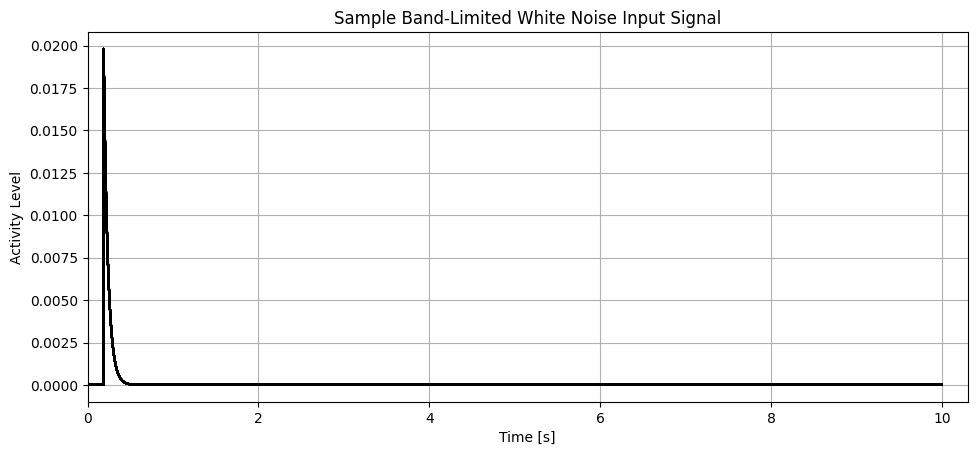

In [12]:
f, pl= plt.subplots(1,1)
f.subplots_adjust(right=1.5)

#syntax --> [;,0] -> indexing a 2D array or matrix

for i in range(49):
    pl.plot(sim.trange(), sim.data[p_stim][:,2], 'k')
    pl.set_title("Sample Band-Limited White Noise Input Signal")
    pl.set_ylabel("Activity Level")
    pl.set_xlabel("Time [s]")
    pl.set_xlim(0,10.3)

#increase synpanse constant (to stretch them out TBD)
#try to incorporate nengo representation to spread
    
pl.grid()

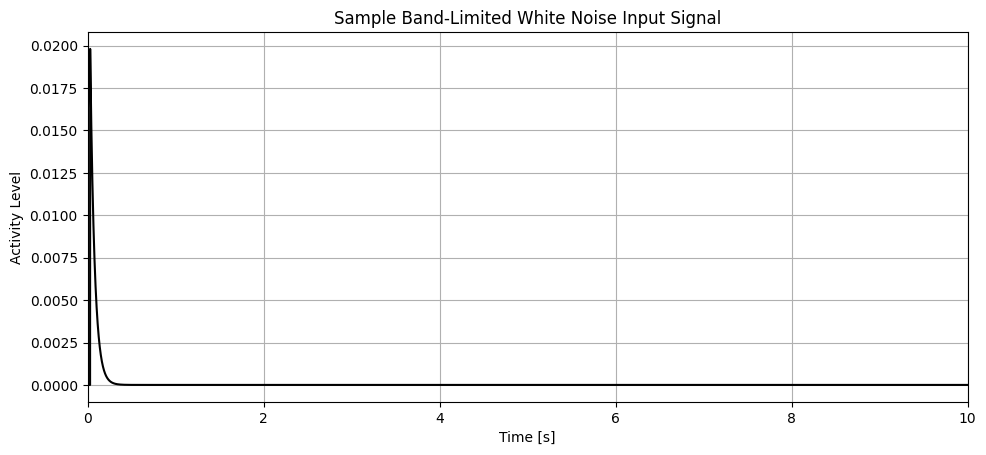

In [13]:
f, pl= plt.subplots(1,1)
f.subplots_adjust(right=1.5)

#syntax --> [;,0] -> indexing a 2D array or matrix


pl.plot(sim.trange(), sim.data[p_stim][:,4], 'k')
pl.set_title("Sample Band-Limited White Noise Input Signal")
pl.set_ylabel("Activity Level")
pl.set_xlabel("Time [s]")
pl.set_xlim(0,10)

#increase synpanse constant (to stretch them out TBD)
#try to incorporate nengo representation to spread
    
pl.grid()

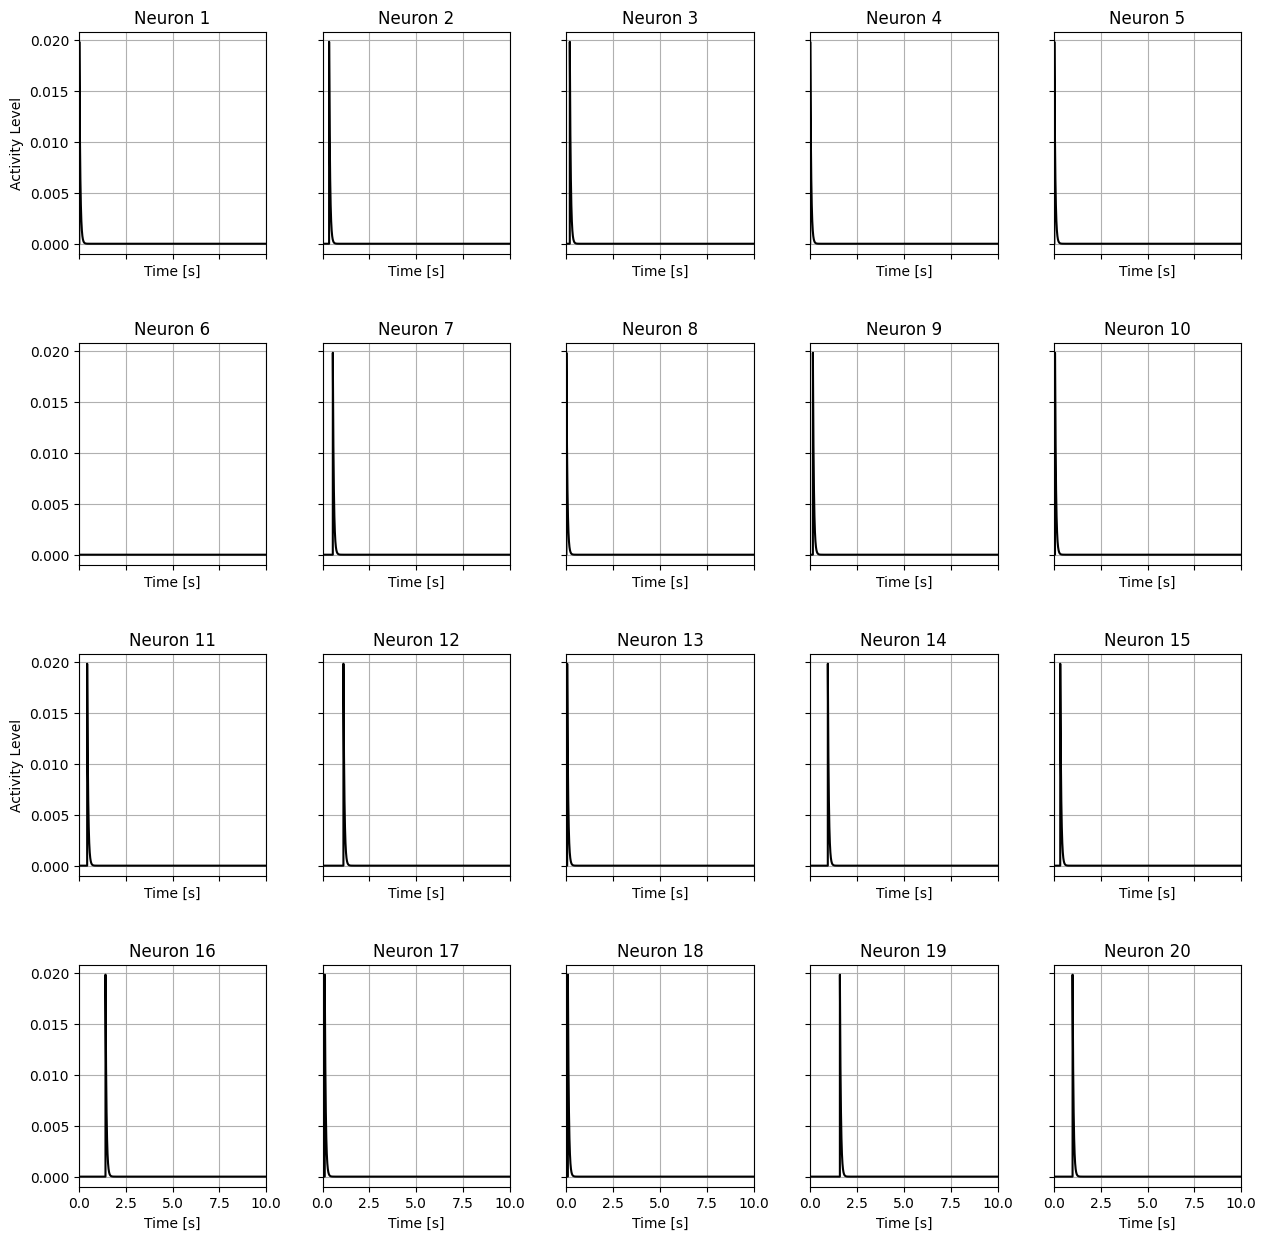

In [14]:
import matplotlib.pyplot as plt

# Number of neurons to plot
num_plots = 20  
rows = 2
cols = 10  # 2 rows, 10 columns

# Create subplots
fig, axes = plt.subplots(4, 5, figsize=(15, 15), sharey=True, sharex=True)

# Adjust layout to prevent overlap
fig.subplots_adjust(wspace=0.3, hspace=0.4)  # Space between plots

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each neuron in a separate subplot
for i in range(20):
    axes[i].plot(sim.trange(), sim.data[p_stim][:, i], 'k')
    axes[i].set_title(f"Neuron {i+1}")
    axes[i].set_xlabel("Time [s]")
    axes[i].set_xlim(0, 10)
    axes[i].grid()

# Set common labels
axes[0].set_ylabel("Activity Level")
axes[10].set_ylabel("Activity Level")  # Label on second row

# Show the plots
plt.show()


In [16]:
sim_t= 50
delay=0.5
with model:
    err_node= nengo.Node(lambda t,x:x if t<sim_t*0.8 else 0, size_in=49 )
    nengo.Connection(stim, err_node,synapse=IdealDelay(delay), transform=-1)
    p_err= nengo.Probe(err_node)

with nengo.Simulator(model, seed=0) as sim:
    sim.run(10)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:06.                                                 


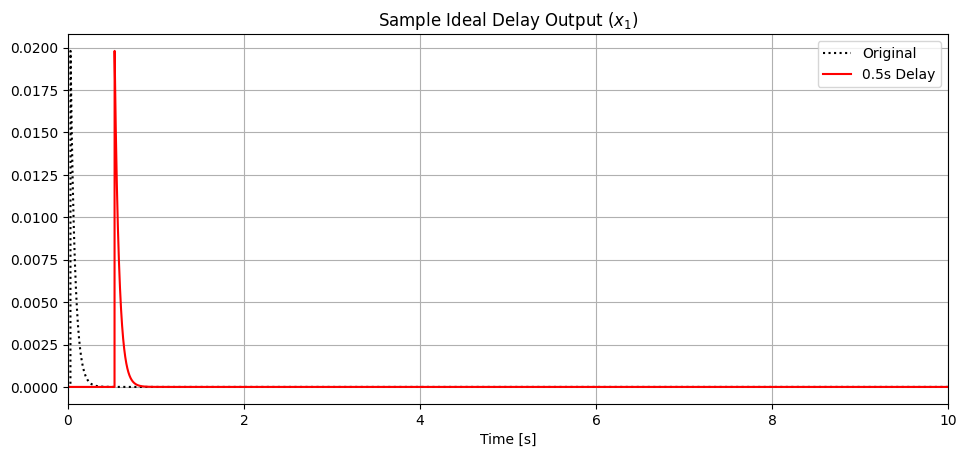

In [17]:
f, pl = plt.subplots(1,1)
f.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_stim][:,0], 'k:', label="Original")
pl.plot(sim.trange(), -sim.data[p_err][:,0], 'r', label="0.5s Delay")
pl.set_title("Sample Ideal Delay Output ($x_{1}$)")
pl.set_xlabel("Time [s]")
pl.set_xlim(0,10)
pl.legend()
pl.grid()

Introducing the LMU's

In [18]:
# Model Parameters
n_ensemble_neurons = 3000
ensemble_radius = 1     # ? Represents the range of values for the neurons?
ensemble_synapse = 0.025
probe_synapse = 0.01
running_time = 10
training_time = 0.8*running_time # WHen does the model stop learning

In [27]:
dimensions = num_neurons
out_dimension= 2
num_degree= 2
neurons= 100
proj_dim = 2

with model:

    #creating the nodes
    lmu_set= LMUStack(proj_dim, order= num_degree)

    
    target_node = nengo.Node(lambda t: target_out[:,int(t / dt) - 1]) 
    inhib_node = nengo.Node(output=lambda t: t >= training_time)


    #creating the ensembles
    rep_ens= nengo.Ensemble(n_ensemble_neurons, 49, ensemble_radius)
    intermediate_ens= nengo.Ensemble(dimensions*num_degree*neurons, proj_dim*num_degree) #
    out_ens = nengo.Ensemble(n_ensemble_neurons, out_dimension, ensemble_radius)
    err_ens = nengo.Ensemble(n_ensemble_neurons, out_dimension, ensemble_radius)

    
    #creating the connections
    #connecting stim with LMU stack
    stim_rep_ens_connection = nengo.Connection(stim, rep_ens)
    rep_lmu_connection = nengo.Connection(rep_ens, lmu_set.input, transform=np.random.normal(0,1,(proj_dim, dimensions)))
    
    lmu_intermediate_connection = nengo.Connection(lmu_set.output, intermediate_ens)
    learning_connection= nengo.Connection(intermediate_ens, out_ens, function= lambda x:[0,0], learning_rule_type=nengo.PES(learning_rate= 2e-4))

    nengo.Connection(out_ens, err_ens)

    nengo.Connection(err_ens, learning_connection.learning_rule)
    inhib_lrn_con = nengo.Connection(inhib_node, err_ens.neurons, transform=-20 * np.ones((err_ens.n_neurons, 1))) 

    p_out = nengo.Probe(out_ens, synapse=probe_synapse)
    p_err = nengo.Probe(err_ens, synapse=probe_synapse)


with nengo.Simulator(model, seed=0) as sim:
    sim.run(10)


Build finished in 0:01:02.                                                      
Simulation finished in 0:00:47.                                                 


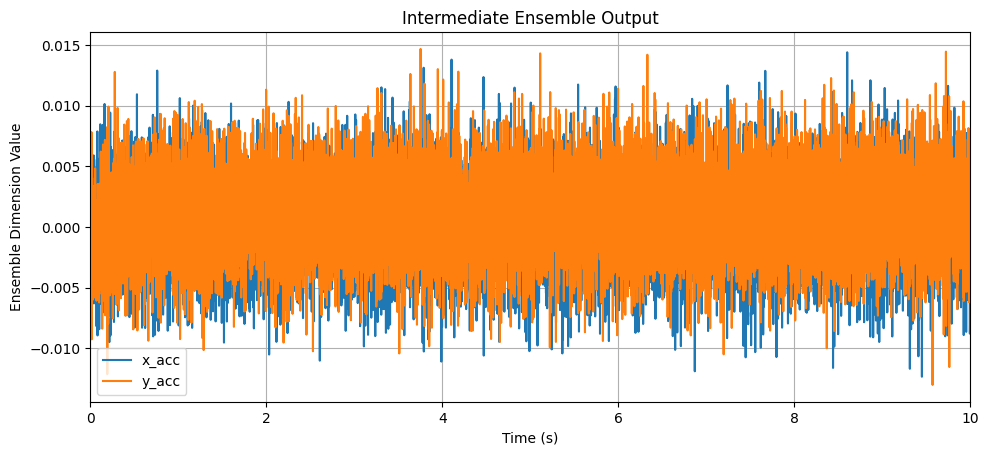

In [28]:
# For the outputs
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_out])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

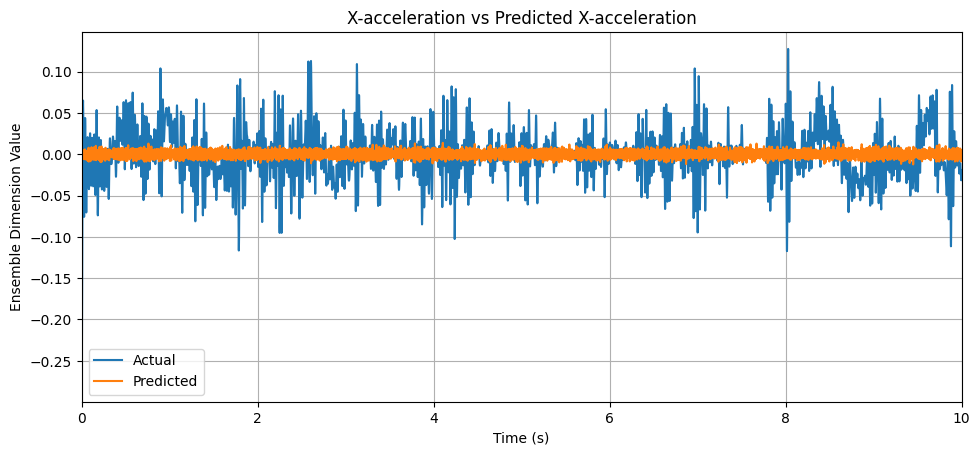

In [29]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[0, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 0])
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

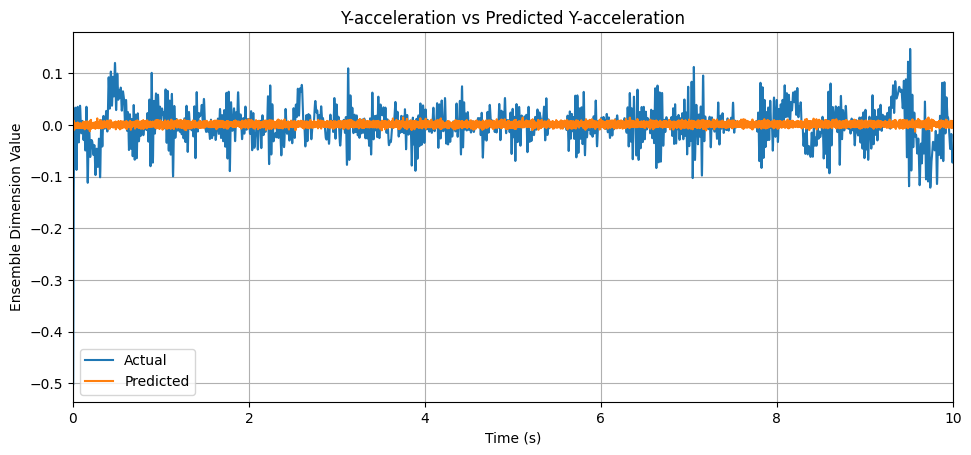

In [30]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[1, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 1])
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

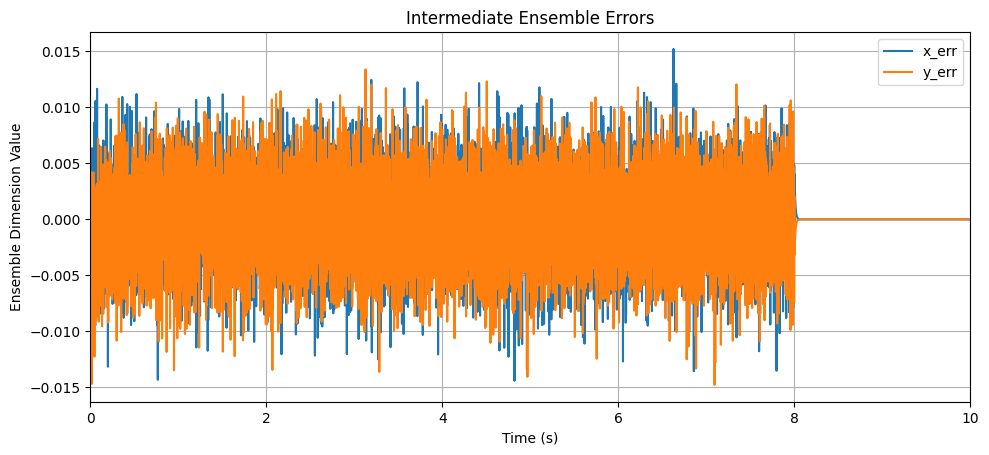

In [31]:
# For the errors
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_err])
pl.set_title("Intermediate Ensemble Errors")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_err", "y_err"])
pl.grid()

In [32]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

In [33]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(target_out[0, 0:len(sim.trange())], sim.data[p_out][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(target_out[1, 0:len(sim.trange())], sim.data[p_out][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.02152923623972612
Root Mean_Squared Error: 0.02939262182209568

Y-Acceleration Error
Mean Absolute Error: 0.023752132495676065
Root Mean_Squared Error: 0.033425321314411456

